In [63]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# specific libraries or classes needed for the work in this notebook
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.metrics import roc_auc_score

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate

# Replication 02: Grid Search

The purpose of this notebook is to set up an effective grid search of meta parameters.  We want to grid search on some basic model parameters.  But more
importantly, we want to vary feature selection, outlier handling, data scaling, etc.  And we want to perform our own leave-one-participant-out
cross validation for the evaluation.

# Integrate Leave-one-participant-out Cross Validation

Grid search can perform its own cross validation.  But we need to control the cross validation to do it by the participan_id groups.

Lets start by creating a grid search over `LogisticRegression` metaparameters, and get the cross validation set up as we need for these
replication experiments.  While we are at it, we can specify using auc-roc score for the test scores here as well.

In [2]:
# we will just use the full set of unscaled features to first try a basic grid search for logistic regression classifiers
df_features = mindwandering.data.get_df_features()
df_label = mindwandering.data.get_df_label()
df_label = df_label.mind_wandered_label

In [3]:
# just a small example
parameters = {
    'solver': ['lbfgs'],
    'C': [1.0, 5.0],
    'max_iter': [15000],
}

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, parameters, scoring='roc_auc', verbose=2)
grid_search.fit(df_features, df_label)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ................C=1.0, max_iter=15000, solver=lbfgs; total time=   5.7s
[CV] END ................C=1.0, max_iter=15000, solver=lbfgs; total time=   8.0s
[CV] END ................C=1.0, max_iter=15000, solver=lbfgs; total time=   5.9s
[CV] END ................C=1.0, max_iter=15000, solver=lbfgs; total time=   7.3s
[CV] END ................C=1.0, max_iter=15000, solver=lbfgs; total time=   4.8s
[CV] END ................C=5.0, max_iter=15000, solver=lbfgs; total time=   5.0s
[CV] END ................C=5.0, max_iter=15000, solver=lbfgs; total time=   5.8s
[CV] END ................C=5.0, max_iter=15000, solver=lbfgs; total time=   7.3s
[CV] END ................C=5.0, max_iter=15000, solver=lbfgs; total time=   7.3s
[CV] END ................C=5.0, max_iter=15000, solver=lbfgs; total time=   6.1s


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1.0, 5.0], 'max_iter': [15000],
                         'solver': ['lbfgs']},
             scoring='roc_auc', verbose=2)

In [4]:
grid_search.cv_results_['mean_test_score']

array([0.59415469, 0.59502235])

Accuracy score:         0.7365063788027478
Recall (TPR) score:     0.10152740341419586
Precision score:        0.6042780748663101
AUC-ROC score:          0.5382763577988967

True positives:   113
True negatives:   2889
False positives:  74
False negatives:  1000
True Positive Rate (recall):  0.10152740341419586
False Positive Rate:          0.024974687816402295
Specificity:                  0.9750253121835977

[[2889   74]
 [1000  113]]


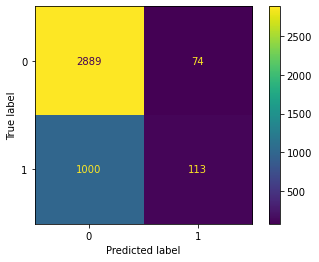

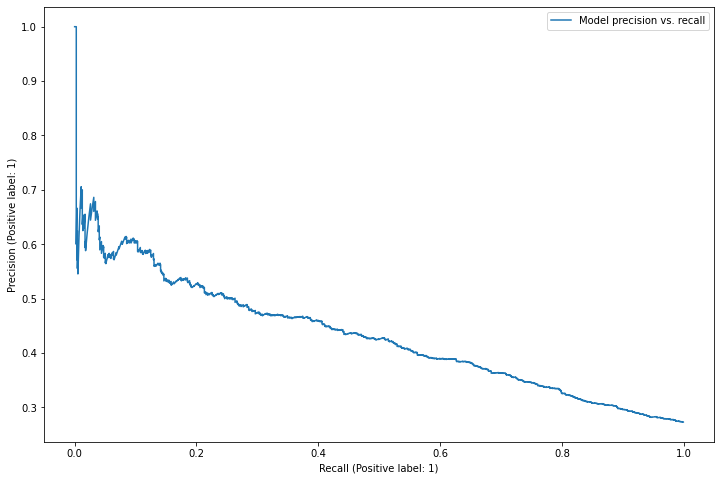

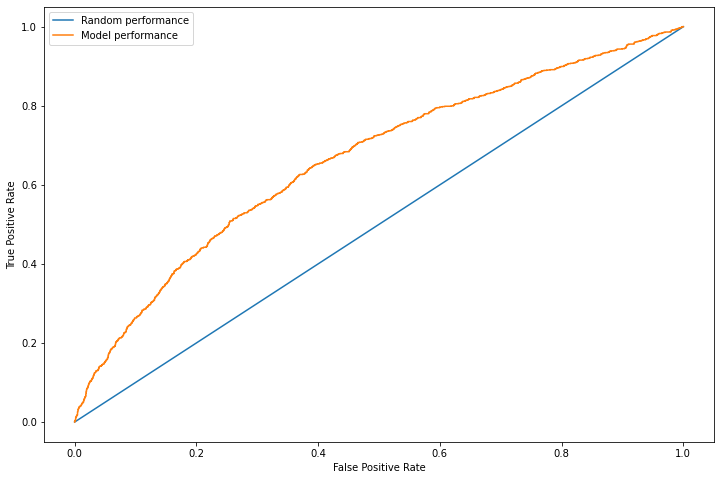

In [5]:
# display results for the best estimator we found
predictions = grid_search.best_estimator_.predict(df_features)
probabilities = grid_search.best_estimator_.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(df_label, predictions, probabilities)

And then, on further inspection of the `GridSearchCV`, you can specify the cv splitting strategy.  So it may not be as tough to integrate the leave-one-participant-out
cv strategy, we sould be able to create the correct splitter and then specify that for the grid search object.

In [6]:
# reload features and labels to ensure clean, also need the participant_id now
df_features = mindwandering.data.get_df_features()

df_label = mindwandering.data.get_df_label()
df_label = df_label.mind_wandered_label

df_experiment_metadata = mindwandering.data.get_df_experiment_metadata()

In [7]:
# first create our leave-one-participant out splitter
participant_ids = df_experiment_metadata.participant_id
logo = LeaveOneGroupOut()

In [ ]:
# just a small example
parameters = {
    'solver': ['lbfgs'],
    'C': [1.0, 5.0],
    'max_iter': [15000],
}

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, parameters, scoring='roc_auc', 
                           verbose=2, 
                           cv=logo.split(df_features, df_label, groups=participant_ids))
grid_search.fit(df_features, df_label)

In [ ]:
grid_search.cv_results_['mean_test_score']

That is going to be problematic.  It is true that some of the participants had no mind wanderings
recorded in our data.  We could drop those participants.  However, really for the model building
with simple ML we are doing here, there is no training that takes place using feedback on the evaluation
metric (e.g. the auc-roc score is not a loss measure here).  I think the correct approach is then to just
grid search using accuracy, and then after models are done, we should evaluate the auc-roc score ourselfs by
hand for all models.  Likely it will usually be the case that the high accuracy will have the highest auc-roc
score, but maybe not always.

# Add non-Model MetaParameters to the Grid Search

There may be a better way to do this, but if so haven't found it yet in scikit-learn documentation.

We can add in metaparameters for our different feature selection and filtering by creating a custom
fit-predictor classifier.  Basically we will remember the metaparameters that our grid searchs specifies
for us in the constructor.  Then in the fit, we construct the model with the model meta parameters, but we
will also need to transform the df_features based on our project meta parameters.

In [93]:
from sklearn.base import BaseEstimator, ClassifierMixin

class LogisticRegressionMindwanderingClassifier(BaseEstimator, ClassifierMixin):
    """A custom classifer that receives the project metaparameters we want to
    grid search on, and sets up correct df_features input data, as well as the
    model to train.  This class is wrapping a LogisticRegression classifier, but we
    can maybe wrap multiple (or is it better to use 1 clase for each)?
    """
    # class variable, so we can count candidate grid searches in our self-made progress
    num_fits = 1
    
    def __init__(self, solver='lbfgs', C=1.0, max_iter=10000,
                use_standard_scaled_features=True,
                clip_outliers=False):
        """We need to support all of the parameters that the grid search will pass in when
        constructing this model as default value parameters.
        """
        # logistic regression meta-parameters
        self.solver = solver
        self.C = C
        self.max_iter = max_iter
        
        # mindwandering project meta-parameters
        self.use_standard_scaled_features = use_standard_scaled_features
        self.clip_outliers = clip_outliers
        
        # print out our own progress message, the built in one for grid search
        # doesn't quite do what I want
        print('Fit %03d:' % LogisticRegressionMindwanderingClassifier.num_fits)
        LogisticRegressionMindwanderingClassifier.num_fits += 1
        
    def _transform_df_features(self, df_features):
        """Given a set of features, transform the features according to the mindwandering
        project meta parameters.
        """
        # make a copy before doing transformations
        df_features = df_features.copy()
        #print('_transform_df_features (before): ', df_features.shape)
        
        # if asked to perform standard scaling, standard scale the features
        if self.use_standard_scaled_features:
            df_features = mindwandering.data.transform_df_features_standard_scaled(df_features)
        #print('_transform_df_features (after): ', df_features.shape)
        
        # perform outlier clipping transformations
        if self.clip_outliers:
            df_features = mindwandering.data.transform_df_features_outliers_removed(df_features)
        
        return df_features

            
    def fit(self, df_features, df_label=None):
        """We have two tasks when the grid search askes us to fit.
        1) transform the df_features dataframe according to the mindwandering project meta-parameters.
        We will use a private member function to do this because many other methods need to share
        this (they can always be passed in a new/different df_features to fit, predict, score, etc.)
        2) Create a LogisticRegression model, using the LogisticRegression model meta-parameters, and then
        fit it to the transformed df_features.
        """
        # get transformed features to fit model with
        #df_features = self._transform_df_features(df_features)
        #print('fit (after): ', df_features.shape)
        #print('fit (after): ', df_features.mean())
        #print('fit (after): ', df_features.std())
        
        # now create a LogisticRegression instance
        self.log_reg = LogisticRegression(solver=self.solver, C=self.C, max_iter=self.max_iter)
        self.log_reg.fit(df_features, df_label)
        
        # probably a better way to do this, after fit some scorers are using some
        # attributes.  So copy attribute from the fitted model
        self.classes_ = self.log_reg.classes_
        self.coef_ = self.log_reg.coef_
        self.intercept_ = self.log_reg.intercept_
        self.n_iter_ = self.log_reg.n_iter_
        
        #print('fit (after model fitted): ', self.log_reg)
        #print('fit predictions: ', sum(self.log_reg.predict(df_features)))
        
        return self
    
    def predict(self, df_features):
        """Provide a prediction method for this classifier.  Just use the prediction method of
        our currently fitted model.
        """
        return self.log_reg.predict(df_features)

    def predict_proba(self, df_features):
        """Provide a method to calculation and return predicition probabilities.
        """
        return self.log_reg.predict_proba(df_features)
    
    def decision_function(self, df_features):
        """Provide method to predict confidence scores for samples
        """
        return self.log_reg.decision_function(df_features)
    
    

With our classifier wrapper, we can then do a grid search, specifying mindwandering meta parameters.

In [59]:
# reload features and labels to ensure clean, also need the participant_id now
df_features = mindwandering.data.get_df_features()

df_label = mindwandering.data.get_df_label()
df_label = df_label.mind_wandered_label

df_experiment_metadata = mindwandering.data.get_df_experiment_metadata()

In [60]:
# first create our leave-one-participant out splitter
participant_ids = df_experiment_metadata.participant_id
logo = LeaveOneGroupOut()

In [ ]:
# just a small example
parameters = {
    'solver': ['lbfgs'],
    'C': [1.0, 5.0],
    'max_iter': [20000],
    'use_standard_scaled_features': [True],
    'clip_outliers': [False, True]
}

log_reg = LogisticRegressionMindwanderingClassifier()
grid_search = GridSearchCV(log_reg, parameters, 
                           scoring='accuracy', 
                           verbose=1, 
                           cv=logo.split(df_features, df_label, groups=participant_ids))
grid_search.fit(df_features, df_label)

# Approximation using Simple Group 5-Fold Cross Validation

The leave-one-participant-out cross validation really slows down the search.

I am thinking perhaps we can try running searches preliminary using 5-fold cross validation.  If any promising model is found with that, we could then
usle leave-one-out cross validation to confirm the model performance when we ensure participants are grouped.

Another better approach might be to use group folding, but allow say 25 subjects in the test group.  This would end up about the same as 5-fold
($5 \times 25 = 125$, 135 participants), while keeping trials of participants from being both in train and test.

Hopefully that would speed up the process, so we can explore the parameter spaces faster.  And here, we can also work out how to gather the data and plot
the results.

In [94]:
# reload features and labels to ensure clean, also need the participant_id now
df_features = mindwandering.data.get_df_features()

df_label = mindwandering.data.get_df_label()
df_label = df_label.mind_wandered_label

df_experiment_metadata = mindwandering.data.get_df_experiment_metadata()

In [96]:
# just a small example
parameters = {
    'solver': ['lbfgs', 'saga'],
    'C': [0.1, 1.0, 5.0, 10.0],
    'max_iter': [50000],
    'use_standard_scaled_features': [False, True],
    'clip_outliers': [False, True]
}

# first create our leave-one-participant out splitter, here we use a 5-Fold CV, folded by participant_id
participant_ids = df_experiment_metadata.participant_id
group_k_fold = GroupKFold(n_splits=5)

# perform the grid search over the model/project parameters
log_reg = LogisticRegressionMindwanderingClassifier()
grid_search = GridSearchCV(log_reg, parameters,
                           scoring=['roc_auc', 'accuracy'],
                           refit='roc_auc',
                           verbose=2, 
                           cv=group_k_fold.split(df_features, df_label, groups=participant_ids))
grid_search.fit(df_features, df_label)

Fit 005:
Fit 006:
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fit 007:
[CV] END C=0.1, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   4.6s
Fit 008:
[CV] END C=0.1, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   5.0s
Fit 009:
[CV] END C=0.1, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   5.3s
Fit 010:
[CV] END C=0.1, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   4.1s
Fit 011:
[CV] END C=0.1, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   5.3s
Fit 012:
[CV] END C=0.1, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=   5.0s
Fit 013:
[CV] END C=0.1, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=   5.0s
Fit 0

/opt/anaconda3/envs/py3gpu/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=  10.3s
Fit 088:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   7.5s
Fit 089:


/opt/anaconda3/envs/py3gpu/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=  10.5s
Fit 090:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   7.7s
Fit 091:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   7.1s
Fit 092:


/opt/anaconda3/envs/py3gpu/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=  10.4s
Fit 093:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=   7.4s
Fit 094:


/opt/anaconda3/envs/py3gpu/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=  10.5s
Fit 095:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=   7.7s
Fit 096:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=   6.6s
Fit 097:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=saga, use_standard_scaled_features=False; total time=  27.5s
Fit 098:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=saga, use_standard_scaled_features=False; total time=  27.0s
Fit 099:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=saga, use_standard_scaled_features=False; total time=  26.3s
Fit 100:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=saga, use_standard_scaled_features=False; total time=  26.5s
Fit 101:
[CV] END C=5.0, clip_outliers=False, max_iter=50000, solver=saga, use_standard_scaled_feat

/opt/anaconda3/envs/py3gpu/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=  10.5s
Fit 108:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   7.2s
Fit 109:


/opt/anaconda3/envs/py3gpu/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=  10.6s
Fit 110:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   7.7s
Fit 111:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=lbfgs, use_standard_scaled_features=False; total time=   6.9s
Fit 112:


/opt/anaconda3/envs/py3gpu/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=  10.4s
Fit 113:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=   7.6s
Fit 114:


/opt/anaconda3/envs/py3gpu/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=  10.3s
Fit 115:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=   7.6s
Fit 116:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=lbfgs, use_standard_scaled_features=True; total time=   6.7s
Fit 117:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=saga, use_standard_scaled_features=False; total time=  24.9s
Fit 118:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=saga, use_standard_scaled_features=False; total time=  24.4s
Fit 119:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=saga, use_standard_scaled_features=False; total time=  23.4s
Fit 120:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=saga, use_standard_scaled_features=False; total time=  23.7s
Fit 121:
[CV] END C=5.0, clip_outliers=True, max_iter=50000, solver=saga, use_standard_scaled_features=Fal

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f497803aa50>,
             estimator=LogisticRegressionMindwanderingClassifier(),
             param_grid={'C': [0.1, 1.0, 5.0, 10.0],
                         'clip_outliers': [False, True], 'max_iter': [50000],
                         'solver': ['lbfgs', 'saga'],
                         'use_standard_scaled_features': [False, True]},
             refit='roc_auc', scoring=['roc_auc', 'accuracy'], verbose=2)

In [99]:
grid_search.cv_results_['mean_test_roc_auc']

array([0.61145111, 0.61145111, 0.60551159, 0.60550712, 0.61145111,
       0.61145111, 0.60551005, 0.6055116 , 0.61063758, 0.61063758,
       0.60554014, 0.60553112, 0.61063758, 0.61063758, 0.60553109,
       0.60553269, 0.60948372, 0.60948372, 0.60554634, 0.60554481,
       0.60948372, 0.60948372, 0.60553727, 0.60554487, 0.61046368,
       0.61046368, 0.6055387 , 0.60553725, 0.61046368, 0.61046368,
       0.60554338, 0.60554032])

In [100]:
grid_search.cv_results_['mean_test_accuracy']

array([0.72375089, 0.72375089, 0.72374999, 0.72374999, 0.72375089,
       0.72375089, 0.72374999, 0.72374999, 0.72546809, 0.72546809,
       0.72399509, 0.72399509, 0.72546809, 0.72546809, 0.72399509,
       0.72399509, 0.7235058 , 0.7235058 , 0.72399509, 0.72399509,
       0.7235058 , 0.7235058 , 0.72399509, 0.72399509, 0.72497669,
       0.72497669, 0.72399509, 0.72399509, 0.72497669, 0.72497669,
       0.72399509, 0.72399509])

Accuracy score:         0.7342983316977428
Recall (TPR) score:     0.09254267744833783
Precision score:        0.5852272727272727
AUC-ROC score:          0.5339527427066192

True positives:   103
True negatives:   2890
False positives:  73
False negatives:  1010
True Positive Rate (recall):  0.09254267744833783
False Positive Rate:          0.02463719203509956
Specificity:                  0.9753628079649005

[[2890   73]
 [1010  103]]


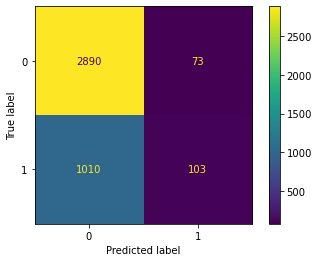

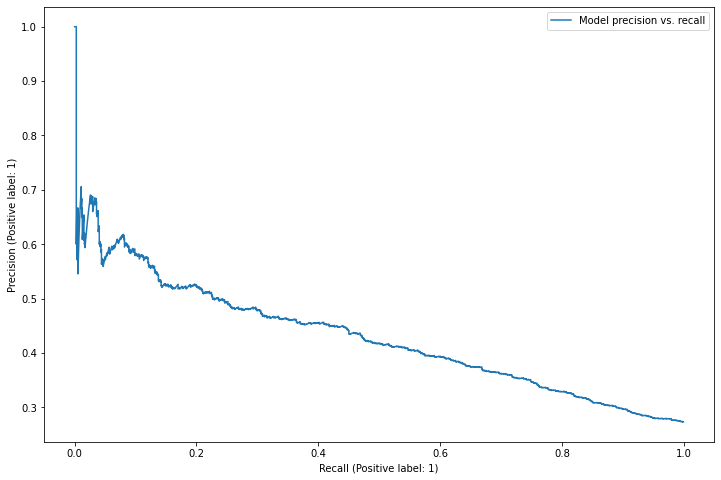

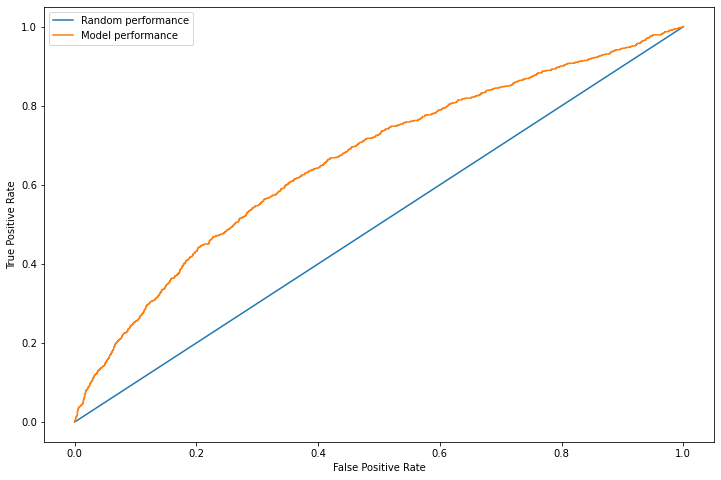

In [101]:
# display results for the best estimator we found
predictions = grid_search.best_estimator_.predict(df_features)
probabilities = grid_search.best_estimator_.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(df_label, predictions, probabilities)

We trained using accuracy.  Lets make a sable of accuracy and auc-roc scores for all models, with which we could construct a histogram.

In [102]:
# the following extracts a nice summary of the results of the grid search.  The mean_test_score is an
# average of the cv split accuracy measurements
result_df = pd.DataFrame(data=grid_search.cv_results_)
result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_clip_outliers,param_max_iter,param_solver,param_use_standard_scaled_features,params,...,std_test_roc_auc,rank_test_roc_auc,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,4.836348,0.457585,0.007981,0.000357,0.1,False,50000,lbfgs,False,"{'C': 0.1, 'clip_outliers': False, 'max_iter':...",...,0.015656,1,0.725490,0.717791,0.726716,0.737101,0.711656,0.723751,0.008624,21
1,4.813813,0.560174,0.008548,0.000930,0.1,False,50000,lbfgs,True,"{'C': 0.1, 'clip_outliers': False, 'max_iter':...",...,0.015656,1,0.725490,0.717791,0.726716,0.737101,0.711656,0.723751,0.008624,21
2,23.780460,0.590605,0.011123,0.002951,0.1,False,50000,saga,False,"{'C': 0.1, 'clip_outliers': False, 'max_iter':...",...,0.016973,30,0.727941,0.717791,0.726716,0.735872,0.710429,0.723750,0.008789,25
3,23.753873,0.561127,0.011323,0.002355,0.1,False,50000,saga,True,"{'C': 0.1, 'clip_outliers': False, 'max_iter':...",...,0.016976,32,0.727941,0.717791,0.726716,0.735872,0.710429,0.723750,0.008789,25
4,4.750678,0.529314,0.008225,0.000336,0.1,True,50000,lbfgs,False,"{'C': 0.1, 'clip_outliers': True, 'max_iter': ...",...,0.015656,1,0.725490,0.717791,0.726716,0.737101,0.711656,0.723751,0.008624,21
5,4.773097,0.516778,0.010553,0.003431,0.1,True,50000,lbfgs,True,"{'C': 0.1, 'clip_outliers': True, 'max_iter': ...",...,0.015656,1,0.725490,0.717791,0.726716,0.737101,0.711656,0.723751,0.008624,21
6,23.729753,0.566884,0.012730,0.004817,0.1,True,50000,saga,False,"{'C': 0.1, 'clip_outliers': True, 'max_iter': ...",...,0.016978,31,0.727941,0.717791,0.726716,0.735872,0.710429,0.723750,0.008789,25
7,23.722291,0.638119,0.014496,0.002357,0.1,True,50000,saga,True,"{'C': 0.1, 'clip_outliers': True, 'max_iter': ...",...,0.016973,29,0.727941,0.717791,0.726716,0.735872,0.710429,0.723750,0.008789,25
8,7.262141,1.440870,0.008109,0.000268,1.0,False,50000,lbfgs,False,"{'C': 1.0, 'clip_outliers': False, 'max_iter':...",...,0.015933,5,0.724265,0.720245,0.732843,0.739558,0.710429,0.725468,0.010078,1
9,7.285643,1.394727,0.008294,0.000461,1.0,False,50000,lbfgs,True,"{'C': 1.0, 'clip_outliers': False, 'max_iter':...",...,0.015933,5,0.724265,0.720245,0.732843,0.739558,0.710429,0.725468,0.010078,1


We can pull out the mean auc_roc and mean accuracy scores from the folds for histograms.

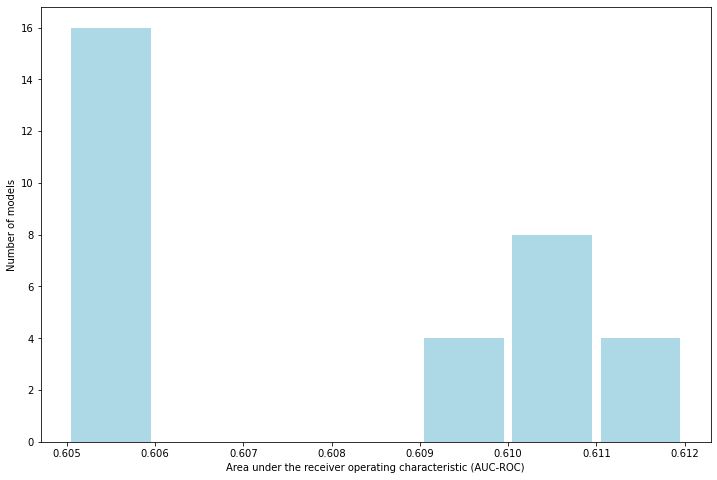

In [115]:
plt.figure(figsize=(12,8))

bins = np.linspace(0.605, 0.612, 8)
plt.hist(result_df.mean_test_roc_auc, 
         bins=bins,
         color='lightblue',
         rwidth=0.9);
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');

Notice that the auc-roc score for the best estimator is consideradbly below that shown for the means over the 5-folds (though accuracy goes up slightly).
The means are of course the average over spliitting data
into 5 groups, and building a model on 4 of the groups while testing on the 5th. The final best model is, I believe, refit on all of the data.  Still kind of disappointing to
see such a drop.  But this indicates maybe that it can overfit, so we need to regularize more?  This can be improved with feature selection (not being used yet), and with the
C parameter.  But I'm not sure why it goes down so much.  And that makes the histogram here a bit of a question of presentation.  But I suspect the histogram in the
reference paper is also on the (average?) leave-one-participant out cross validation.

# Full Test of LogisticRegression with 5-Fold group CV

A full(er) test of grid search using both project meta-parameters and LogisticRegression metaparameters.  Here we really want to add in the feature selection methods used by the
original paper.  We will try both vif and no vif selections, and feature selection of 25%, 50%, 75% and 100% of the parameters.  Actually for vif selection, we will define that as a
parameters like `vif_num_features: [32, 64]', where asking for 64 features means you are not doing any vif trimming.  Also the top X% feature selection can be combined with or
without vif trimming.  If features were trimmed with vir, then the result is the top 25%, 50%, 75% or 100% of the 32 features that survived vif trimming.

Not sure if its worthwile to explore more LogisticRegression meta-parameters at this point.  We could try more C values, and maybe some other solvers, but haven't seen any difference
so far among those either.